In [58]:
# Importing liabraries
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
import os
import datetime
from prophet import Prophet

# Enable inline plotting
%matplotlib inline

# Uncomment the next block if you are testing in order to see the warnings
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [3]:
aep = pd.read_csv("../data/AEP_hourly.csv", index_col=0, parse_dates=True)
df_main = aep.copy()

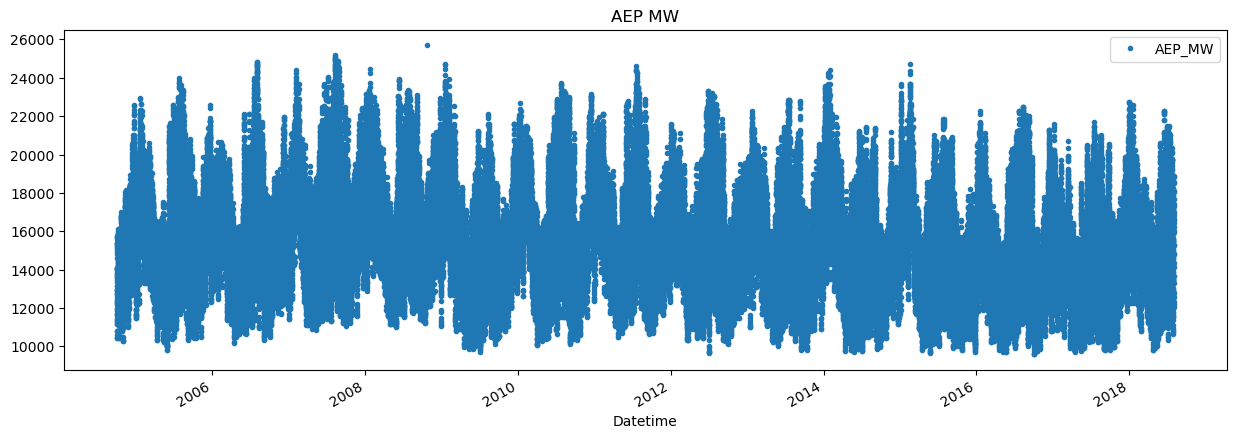

In [4]:
df_main.plot(style='.', figsize=(15,5), title='AEP MW')
plt.show()

# Feature creation to see trends

In [5]:
def create_features(_df, label=None):
    df = _df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_main, label='AEP_MW')

features_and_target = pd.concat([X, y], axis=1)

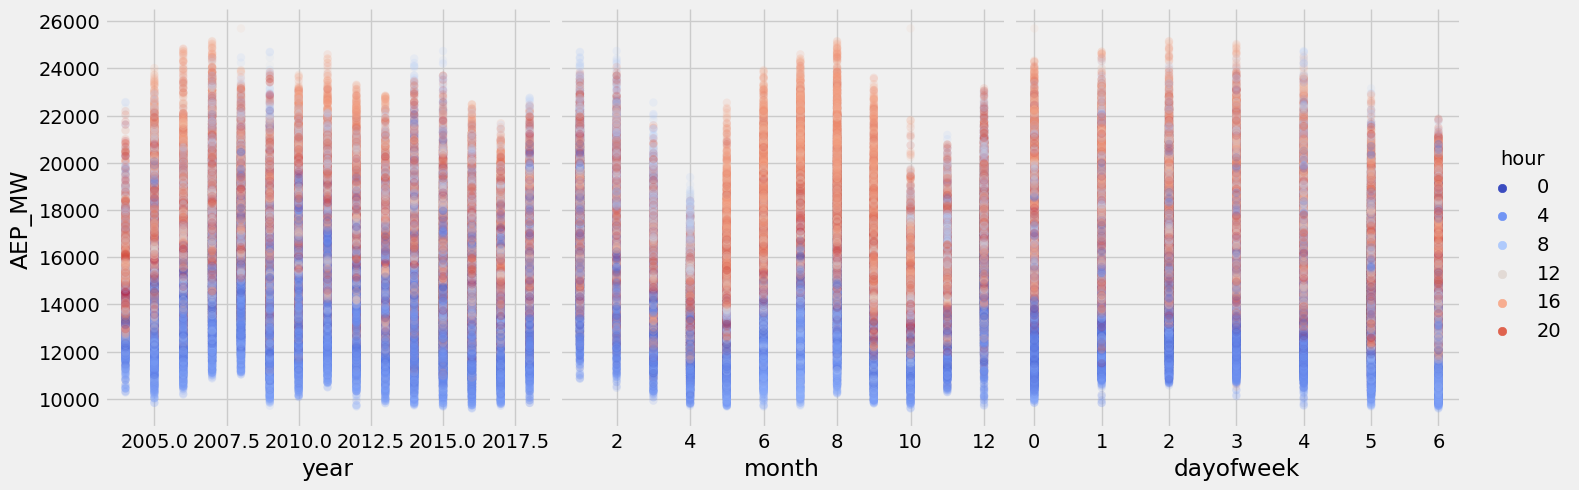

In [6]:
plt.style.use('fivethirtyeight')
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             palette= "coolwarm",
             x_vars=['year','month','dayofweek'],
             y_vars='AEP_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
# plt.suptitle('Power Use GW by Year, Month and Day of Week')
plt.show()

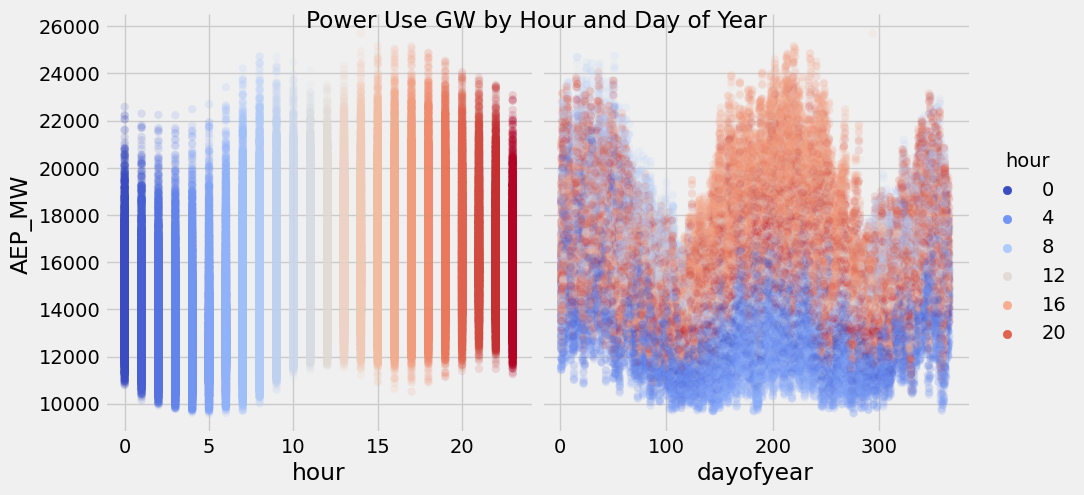

In [7]:
plt.style.use('fivethirtyeight') # For plots
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             palette= "coolwarm",
             x_vars=['hour','dayofyear'],
             y_vars='AEP_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use GW by Hour and Day of Year')
plt.show()

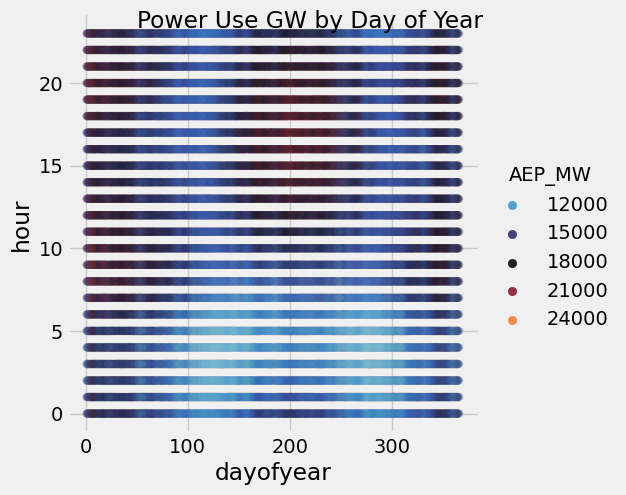

In [8]:
plt.style.use('fivethirtyeight') # For plots
sns.pairplot(features_and_target.dropna(),
             hue='AEP_MW',
             palette= "icefire",
             x_vars='dayofyear',
             y_vars='hour',
             height=5,
             plot_kws={'alpha':0.05, 'linewidth':0}
            )
plt.suptitle('Power Use GW by Day of Year')
plt.show()

# Split data into Train/Test

In [9]:
df_main

AEP_MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0
...                      ...
2018-01-01 20:00:00  21089.0
2018-01-01 21:00:00  20999.0
2018-01-01 22:00:00  20820.0
2018-01-01 23:00:00  20415.0
2018-01-02 00:00:00  19993.0

[121273 rows x 1 columns]

In [10]:
split_date = '2017-01-01 00:00:00'
train = df_main.loc[df_main.index <= split_date].copy()
test = df_main.loc[df_main.index > split_date].copy()

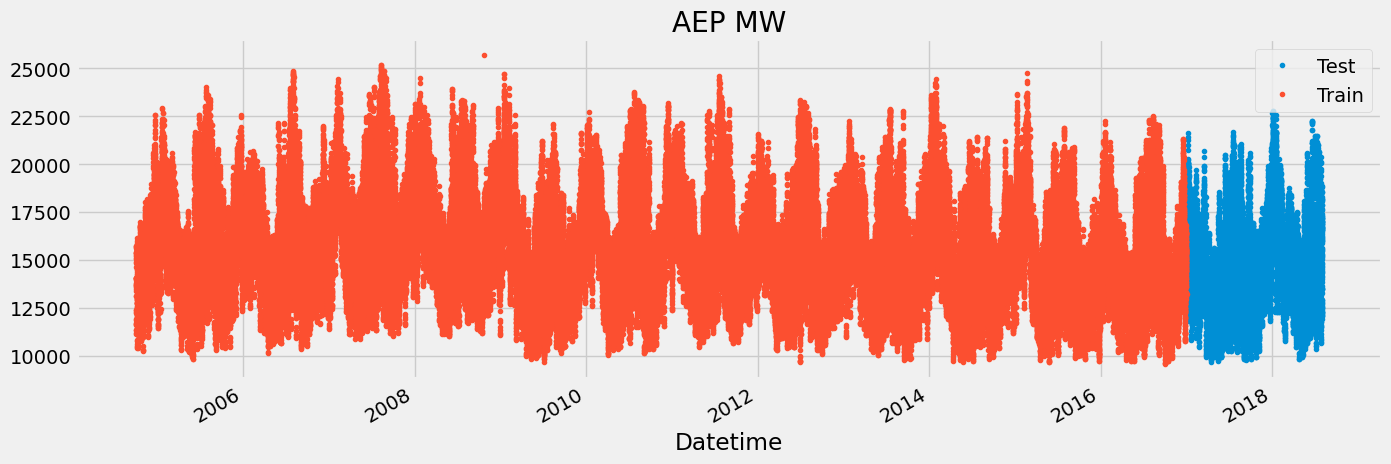

In [11]:
test.rename(columns={'AEP_MW': 'Test'}).join(train.rename(columns={'AEP_MW': 'Train'}),how='outer').plot(figsize=(15,5), title='AEP MW', style='.')
plt.show()

# Prophet model creation

In [12]:
# Format TRAIN data for prophet model using ds and y
train_format = train.reset_index().rename(columns={'Datetime':'ds','AEP_MW':'y'})

# Convert MW to GW. The model creation process gets faster with smaler numbers.
df_div=train_format.copy()
df=df_main.copy()
df_div_y=df_div['y'].div(1000)
train_format["y"]=df_div_y
train_format.head()

ds       y
0 2004-12-31 01:00:00  13.478
1 2004-12-31 02:00:00  12.865
2 2004-12-31 03:00:00  12.577
3 2004-12-31 04:00:00  12.517
4 2004-12-31 05:00:00  12.670

In [60]:
train_format.describe()

y
count  107378.000000
mean       15.592353
std         2.600241
min         9.581000
25%        13.711000
50%        15.409000
75%        17.301000
max        25.695000

In [13]:
# Create the model
params = {  
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 0.01,
    'seasonality_mode': 'multiplicative'
}

m = Prophet(**params)
m.fit(train_format)

c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [14]:
import joblib 
joblib.dump(m, 'm_prophet.pkl') # Save the model

['m_prophet.pkl']

In [15]:
# Format TEST for prophet model using ds and y
test_format = test.reset_index().rename(columns={'Datetime':'ds','AEP_MW':'y'})

# Convert MW to GW. The model creation process gets faster with smaler numbers.
df_div=test_format.copy()
df=df_main.copy()
df_div_y=df_div['y'].div(1000)
test_format["y"]=df_div_y
test_format.head()

ds       y
0 2017-12-31 01:00:00  17.422
1 2017-12-31 02:00:00  17.219
2 2017-12-31 03:00:00  17.313
3 2017-12-31 04:00:00  17.396
4 2017-12-31 05:00:00  17.512

# Make predictions

In [16]:
# Predict on training set with model
forecast = m.predict(df=test_format)

c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [17]:
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2017-01-01 01:00:00  14.623382   10.384621   14.092249    14.623382   
1 2017-01-01 02:00:00  14.623361    9.808742   13.674872    14.623361   
2 2017-01-01 03:00:00  14.623341    9.446216   13.428271    14.623341   
3 2017-01-01 04:00:00  14.623320    9.517821   13.396567    14.623320   
4 2017-01-01 05:00:00  14.623300    9.705473   13.724911    14.623300   

   trend_upper     daily  daily_lower  daily_upper  multiplicative_terms  ...  \
0    14.623382 -0.097639    -0.097639    -0.097639             -0.157151  ...   
1    14.623361 -0.135013    -0.135013    -0.135013             -0.195334  ...   
2    14.623341 -0.156408    -0.156408    -0.156408             -0.217186  ...   
3    14.623320 -0.158720    -0.158720    -0.158720             -0.219595  ...   
4    14.623300 -0.139892    -0.139892    -0.139892             -0.200499  ...   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0 -0.096347     -0.096347     -0.096347  0.036835      0.036835      0.036835   
1 -0.097292     -0.097292     -0.097292  0.036971      0.036971      0.036971   
2 -0.097886     -0.097886     -0.097886  0.037108      0.037108      0.037108   
3 -0.098123     -0.098123     -0.098123  0.037248      0.037248      0.037248   
4 -0.097996     -0.097996     -0.097996  0.037388      0.037388      0.037388   

   additive_terms  additive_terms_lower  additive_terms_upper       yhat  
0             0.0                   0.0                   0.0  12.325306  
1             0.0                   0.0                   0.0  11.766927  
2             0.0                   0.0                   0.0  11.447362  
3             0.0                   0.0                   0.0  11.412109  
4             0.0                   0.0                   0.0  11.691336  

[5 rows x 22 columns]

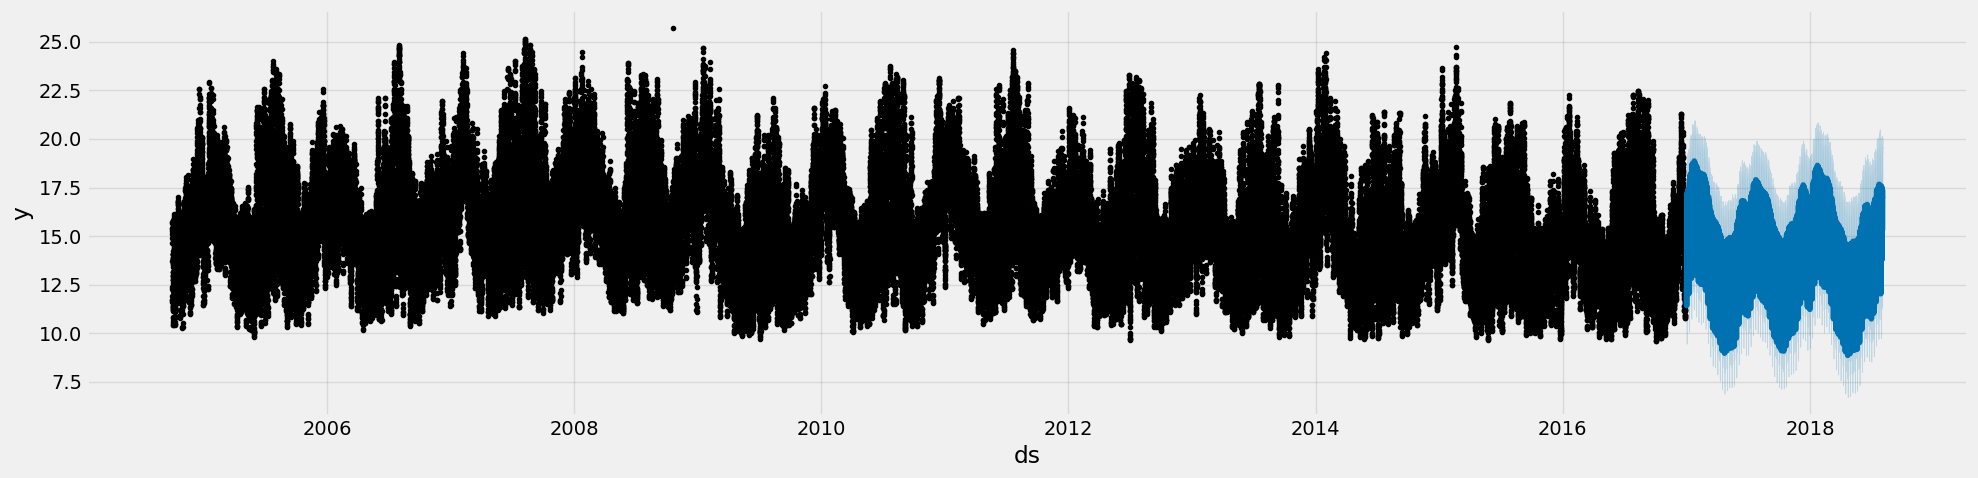

In [18]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
fig = m.plot(forecast,ax=ax)
plt.show()

In [19]:
from prophet.plot import plot_components_plotly
plot_components_plotly(m,forecast)
# fig = model.plot_components(pjme_test_fcst)

c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Compare forecast to actual data

In [20]:
# Convert MW to GW. The model creation process gets faster with smaler numbers.
df_div=test.copy()
df_div_y=df_div['AEP_MW'].div(1000)
test["AEP_MW"]=df_div_y
test.head()

AEP_MW
Datetime                   
2017-12-31 01:00:00  17.422
2017-12-31 02:00:00  17.219
2017-12-31 03:00:00  17.313
2017-12-31 04:00:00  17.396
2017-12-31 05:00:00  17.512

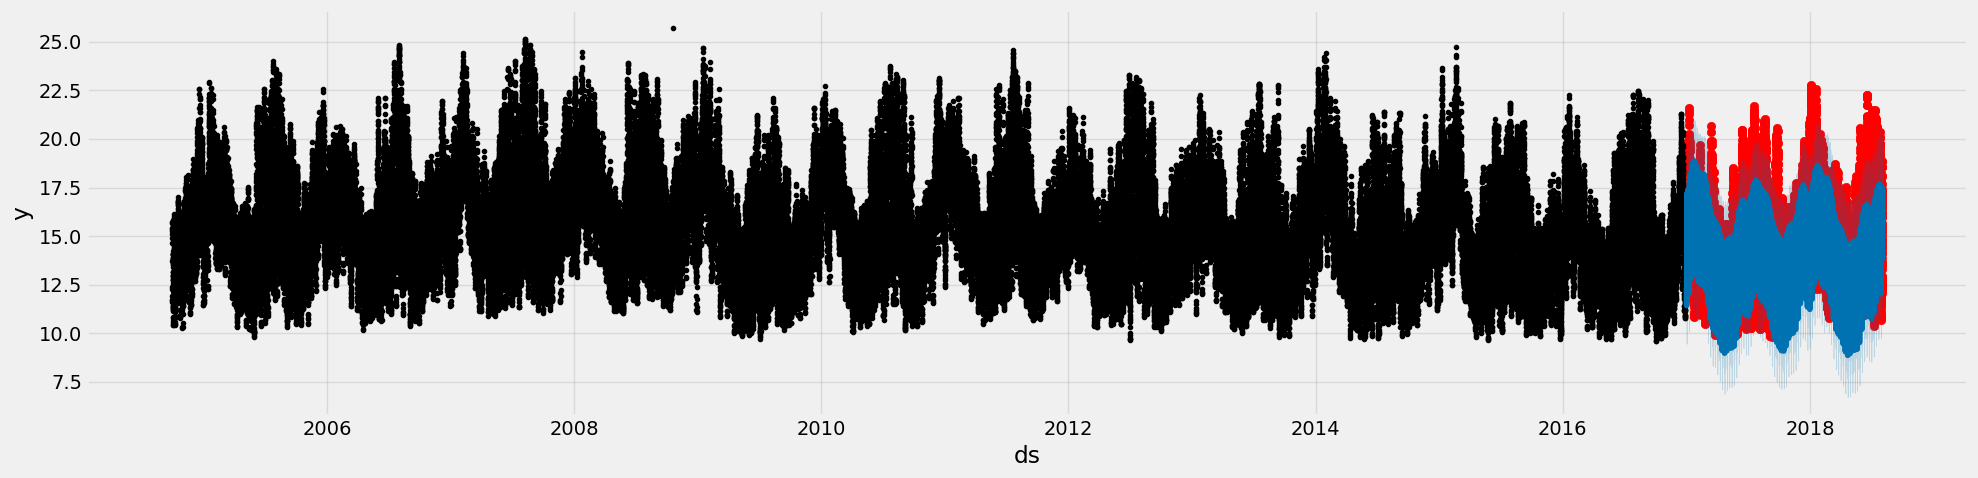

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(test.index, test['AEP_MW'], color='r')
fig = m.plot(forecast, ax=ax)

# Zoom to predictions

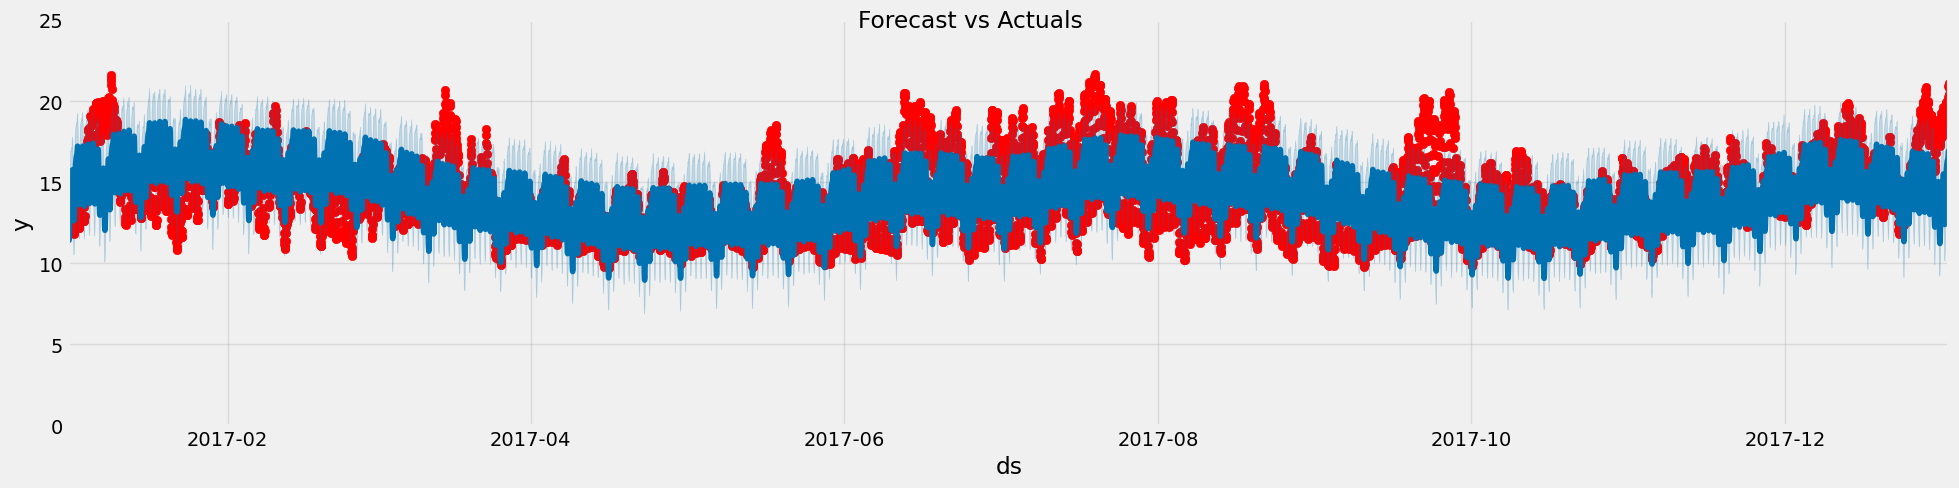

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(test.index, test['AEP_MW'], color='r')
fig = m.plot(forecast, ax=ax)
ax.set_xbound(lower=datetime.datetime(2017, 1, 1),
              upper=datetime.datetime(2018, 1, 2))
ax.set_ylim(0, 25)
plot = plt.suptitle('Forecast vs Actuals')

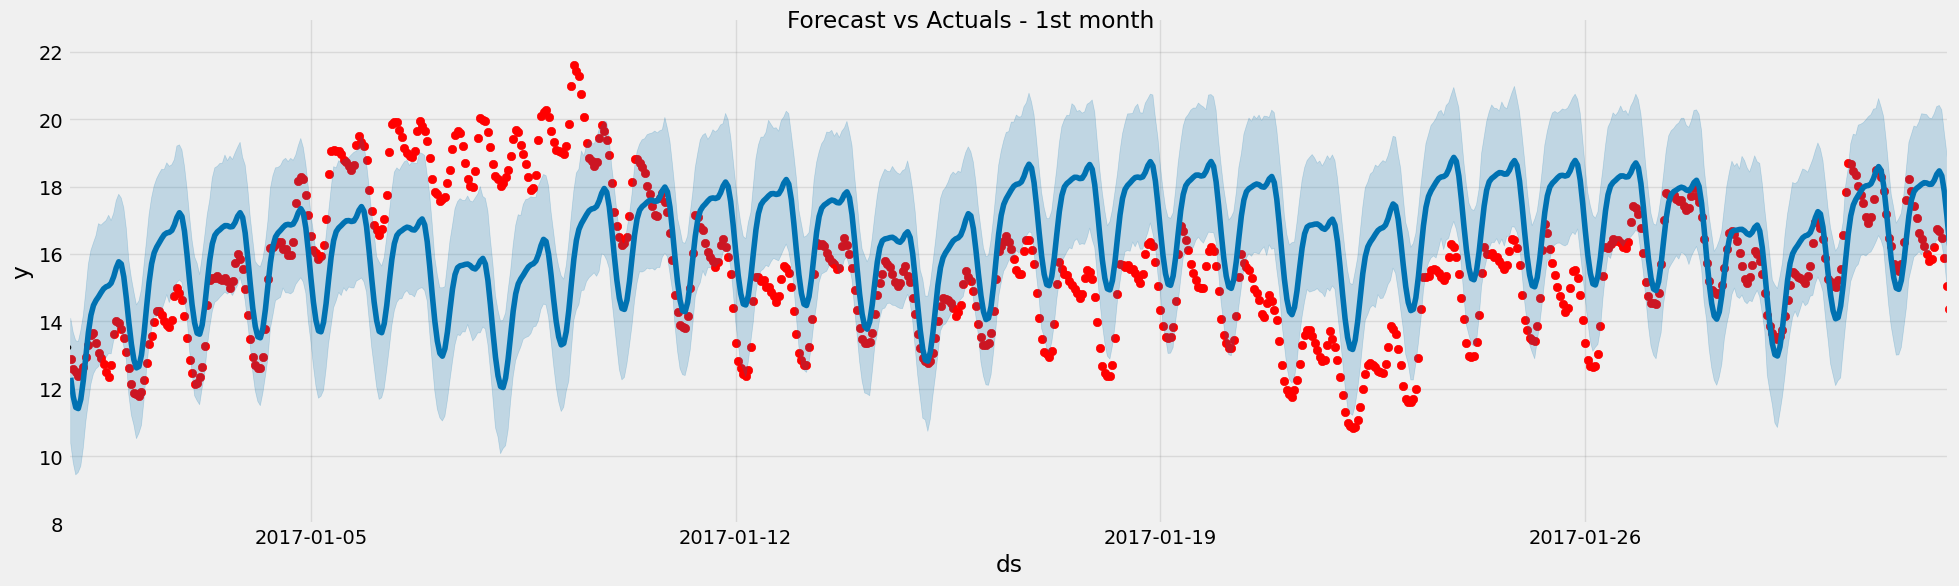

In [23]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(20)
ax.scatter(test.index, test['AEP_MW'], color='r')
fig = m.plot(forecast, ax=ax)
ax.set_xbound(lower=datetime.datetime(2017, 1, 1),
              upper=datetime.datetime(2017, 2, 1))
ax.set_ylim(8, 23)
plot = plt.suptitle('Forecast vs Actuals - 1st month')

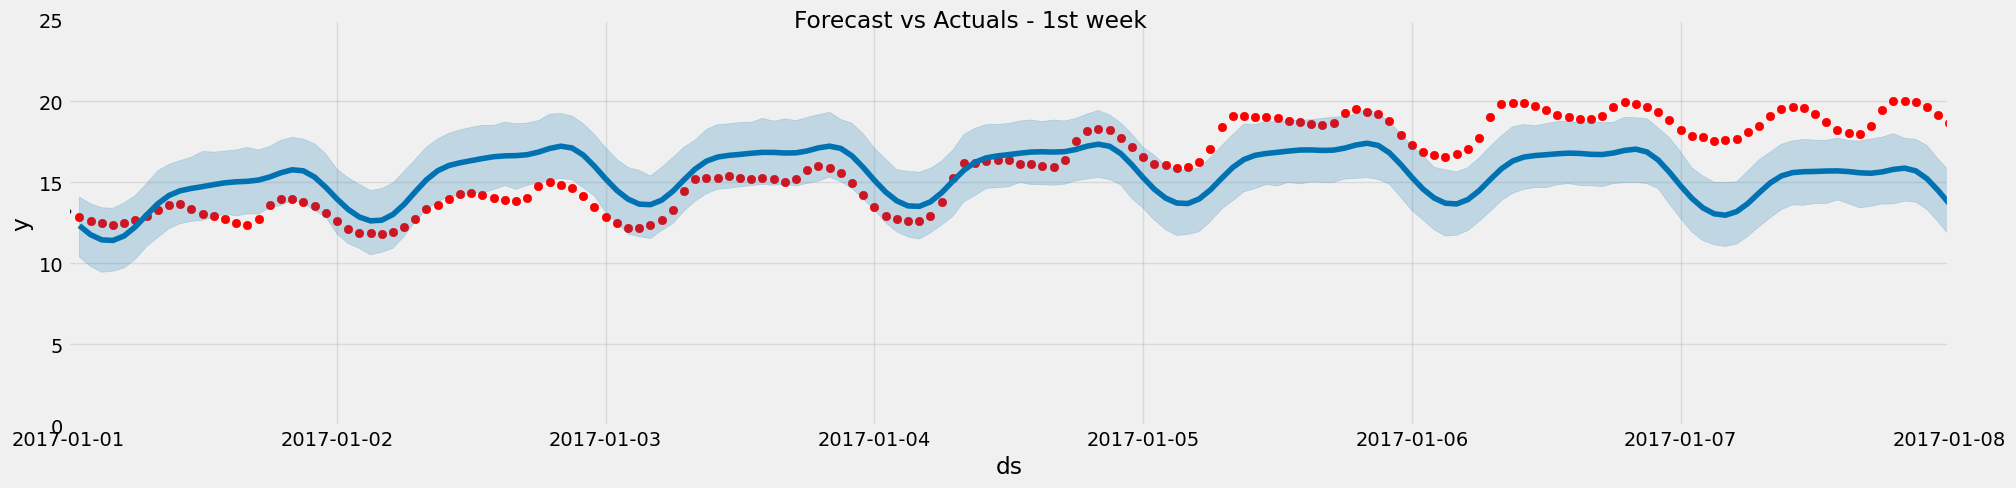

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(test.index, test['AEP_MW'], color='r')
fig = m.plot(forecast, ax=ax)
ax.set_xbound(lower=datetime.datetime(2017, 1, 1),
              upper=datetime.datetime(2017, 1, 8))
ax.set_ylim(0, 25)
plot = plt.suptitle('Forecast vs Actuals - 1st week')

# Model Metrics

## F1-Score, Accuracy & Precision

Calculate F1-score and Accuracy by comparing predictions with actual values. To do this, we will first define a classification threshold. We will use the average value of the training data.

In [25]:
threshold = train_format['y'].mean()

In [26]:
predictions = np.where(forecast['yhat'] > threshold, 1, 0)
actuals = np.where(test['AEP_MW'] > threshold, 1, 0)

from sklearn.metrics import f1_score, accuracy_score, average_precision_score

f1 = f1_score(actuals, predictions)
accuracy = accuracy_score(actuals, predictions)
avg_p = average_precision_score(actuals, predictions)

print("Metrics with Threshold")
print("F1-Score = ", f1)
print("Accuracy = ", accuracy)
print("Average Precision: ", avg_p)

Metrics with Threshold
F1-Score =  0.5470066269796697
Accuracy =  0.709751709247931
Average Precision:  0.4554375275943662


## Mean Squared Error

In [27]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test['AEP_MW'], forecast['yhat'])
se = np.sqrt(mse)

print("Mean Squared Error = ", mse)
print("Mean Error = ", se)

Mean Squared Error =  4.913553409834895
Mean Error =  2.216653651302994


## Other Metrics (without threshold)

In [42]:

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import explained_variance_score

predictions = forecast['yhat']
actuals = test['AEP_MW']

print("r2_score:", r2_score(actuals, predictions))
print("mean_squared_error:", mean_squared_error(actuals, predictions))
print("mean_squared_error (squared=false):", mean_squared_error(actuals, predictions, squared=False))
print("mean_squared_log_error:", mean_squared_log_error(actuals, predictions))
print("mean_absolute_percentage_error:", mean_absolute_percentage_error(actuals, predictions))
print("median_absolute_error:",median_absolute_error(actuals, predictions))
print("max_error:", max_error(actuals, predictions))
print("explained_variance_score:", explained_variance_score(actuals, predictions))

r2_score: 0.149797554416505
mean_squared_error: 4.913553409834895
mean_squared_error (squared=false): 2.216653651302994
mean_squared_log_error: 0.019610093109215156
mean_absolute_percentage_error: 0.11787165321675282
median_absolute_error: 1.4478609874269406
max_error: 8.21114981730808
explained_variance_score: 0.15987490904608337


## Root Mean Squared Error, Mean Absolute Error & Mean Value

In [28]:
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import meanabs

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error


In [29]:
print("Root Mean Squared Error: ",rmse(test['AEP_MW'], forecast['yhat']))
print("Mean Absolute Error: ", meanabs(test['AEP_MW'], forecast['yhat']))
print("Mean Absolute Error (sklearn): ", meanabs(test['AEP_MW'], forecast['yhat']))
mape = mean_absolute_percentage_error(test['AEP_MW'], forecast['yhat'])
mae = mean_absolute_error(test['AEP_MW'], forecast['yhat'])
print("Mean Absolute Percentage Error: ", mape*100, "%")
print("Mean Value of Test Dataset: ", (test['AEP_MW'].mean()))

Root Mean Squared Error:  2.216653651302994
Mean Absolute Error:  1.7505040409032209
Mean Absolute Error (sklearn):  1.7505040409032209
Mean Absolute Percentage Error:  11.787165321675282 %
Mean Value of Test Dataset:  14.782072328175603


## Confusion Matrix

In [49]:
predictions = forecast['yhat']
test_aux = test.reset_index()
actuals = test_aux["AEP_MW"]

# We cannot use a confusion with continuous data, so we have to discretize it

# Define the category bins
bins = np.linspace(actuals.min(), actuals.max(), 11)

# Discretize the values into categories
data_actuals = pd.DataFrame()
data_actuals['value'] = actuals
data_actuals['category'] = pd.cut(actuals, bins=bins, labels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'])
data_predictions = pd.DataFrame()
data_predictions['value'] = predictions
data_predictions['category'] = pd.cut(predictions, bins=bins, labels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'])


In [50]:
# Define the true labels and predicted labels as integers
y_true = data_actuals['category'].tolist()
y_pred = data_predictions['category'].tolist()

# Define the category labels as integers
labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']

# Create the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

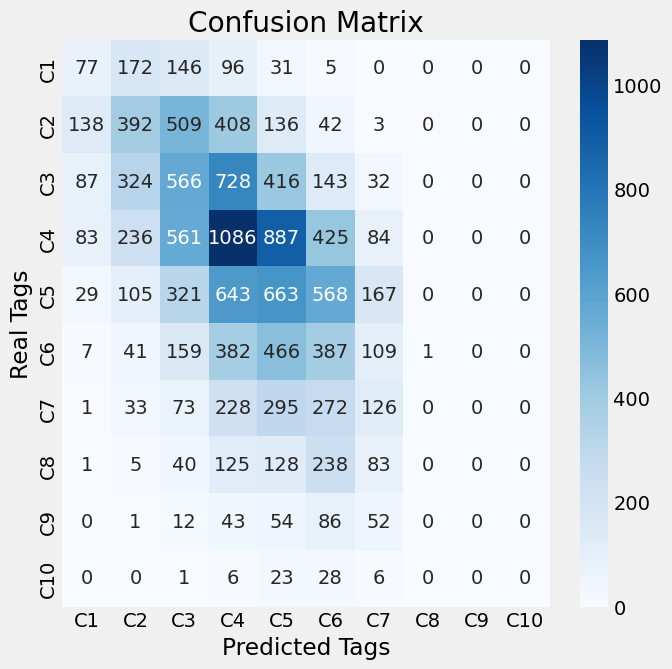

In [52]:
# sns.heatmap(cm, annot=True, cmap='Blues')
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
# labels_GW = [ "9.7" , "11.0", "12.3", "13.6", "14.9", "16.2", "17.5",
#        "18.8", "20.1", "21.5" ]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Real Tags')
plt.show()

### Clasification Metrics Report

In [59]:
from sklearn.metrics import classification_report

labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10','C11']
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

          C1       0.18      0.14      0.16       542
          C2       0.00      0.00      0.00        64
          C3       0.30      0.24      0.26      1652
          C4       0.24      0.24      0.24      2311
          C5       0.29      0.32      0.31      3376
          C6       0.21      0.27      0.24      2501
          C7       0.18      0.25      0.21      1552
          C8       0.19      0.12      0.15      1028
          C9       0.00      0.00      0.00       620
         C10       0.00      0.00      0.00       248
         C11       0.00      0.00      0.00         1

    accuracy                           0.24     13895
   macro avg       0.14      0.14      0.14     13895
weighted avg       0.22      0.24      0.23     13895



### Categorized by Integer Number

In [44]:
predictions = forecast['yhat']
test_aux = test.reset_index()
actuals = test_aux["AEP_MW"]

res_b=predictions.copy()
predictions_int=predictions.copy()
res_b=round(predictions_int).astype("int")
predictions_int=res_b

res_b=actuals.copy()
actuals_int=actuals.copy()
res_b=round(actuals_int).astype("int")
actuals_int=res_b

In [61]:
# Define the category bins
bins = list(range(9, 24))
labels = list(range(9, 23))

# Discretize the values into categories
data_actuals = pd.DataFrame()
data_actuals['value'] = actuals_int
data_actuals['category'] = pd.cut(actuals_int, bins=bins)
data_predictions = pd.DataFrame()
data_predictions['value'] = predictions_int
data_predictions['category'] = pd.cut(predictions_int, bins=bins ,labels=labels)

In [62]:
y_true = data_actuals['value'].tolist()
y_pred = data_predictions['value'].tolist()

# Create the confusion matrix
from sklearn.metrics import confusion_matrix
cm_int = confusion_matrix(y_true, y_pred, labels=labels)

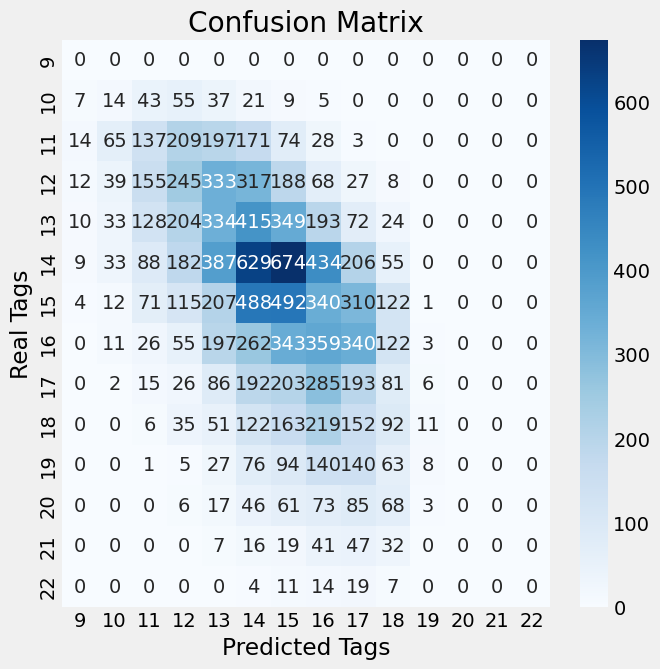

In [37]:
# sns.heatmap(cm, annot=True, cmap='Blues')
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(cm_int, annot=True, cmap='Blues', fmt='g')
# labels_GW = [ "9.7" , "11.0", "12.3", "13.6", "14.9", "16.2", "17.5",
#        "18.8", "20.1", "21.5" ]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Real Tags')
plt.show()

### Clasification Metrics Report

In [65]:
from sklearn.metrics import classification_report

bins = ["9GW", "10GW", "11GW", "12GW", "13GW", "14GW", "15GW", "16GW", "17GW", "18GW", "19GW", "20GW", "21GW", "22GW", "23GW"]
print(classification_report(y_true, y_pred, target_names=bins))

              precision    recall  f1-score   support

         9GW       0.00      0.00      0.00         0
        10GW       0.07      0.07      0.07       191
        11GW       0.20      0.15      0.17       898
        12GW       0.22      0.18      0.19      1392
        13GW       0.18      0.19      0.18      1762
        14GW       0.23      0.23      0.23      2697
        15GW       0.18      0.23      0.20      2162
        16GW       0.16      0.21      0.18      1718
        17GW       0.12      0.18      0.14      1089
        18GW       0.14      0.11      0.12       851
        19GW       0.25      0.01      0.03       554
        20GW       0.00      0.00      0.00       359
        21GW       0.00      0.00      0.00       162
        22GW       0.00      0.00      0.00        55
        23GW       0.00      0.00      0.00         5

    accuracy                           0.18     13895
   macro avg       0.12      0.10      0.10     13895
weighted avg       0.18   

## Confusion Matrix with Threshold

In [38]:
threshold = train_format['y'].mean()
predictions = np.where(forecast['yhat'] > threshold, 1, 0)
actuals = np.where(test['AEP_MW'] > threshold, 1, 0)

In [39]:
# Create the confusion matrix
from sklearn.metrics import confusion_matrix
labels=[0,1]
cm_th = confusion_matrix(actuals, predictions, labels=labels)

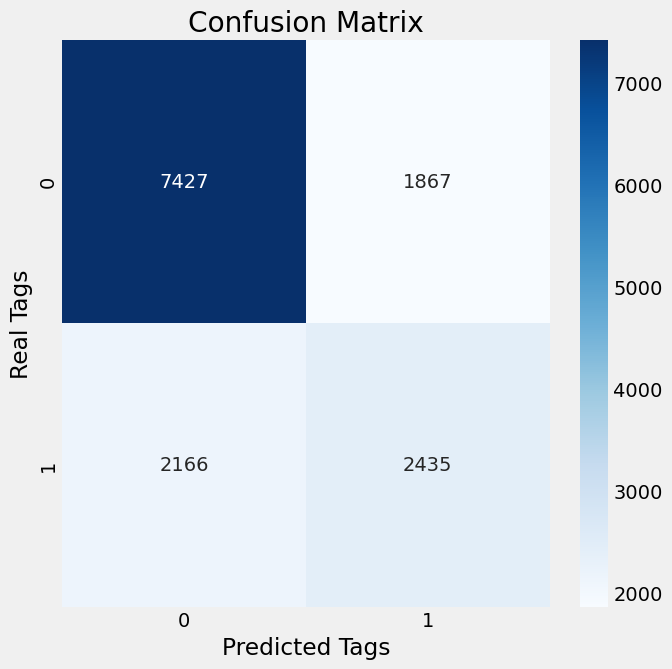

In [40]:
# sns.heatmap(cm, annot=True, cmap='Blues')
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(cm_th, annot=True, cmap='Blues', fmt='g')
# labels_GW = [ "9.7" , "11.0", "12.3", "13.6", "14.9", "16.2", "17.5",
#        "18.8", "20.1", "21.5" ]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Real Tags')
plt.show()

In [41]:
# Calculate the metrics
tn, fp, fn, tp = cm_th.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * precision * recall / (precision + recall)

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("Specificity: {:.2f}".format(specificity))
print("F1-score: {:.2f}".format(f1_score))

Confusion Matrix:
 [[  77  172  146   96   31    5    0    0    0    0]
 [ 138  392  509  408  136   42    3    0    0    0]
 [  87  324  566  728  416  143   32    0    0    0]
 [  83  236  561 1086  887  425   84    0    0    0]
 [  29  105  321  643  663  568  167    0    0    0]
 [   7   41  159  382  466  387  109    1    0    0]
 [   1   33   73  228  295  272  126    0    0    0]
 [   1    5   40  125  128  238   83    0    0    0]
 [   0    1   12   43   54   86   52    0    0    0]
 [   0    0    1    6   23   28    6    0    0    0]]
Accuracy: 0.71
Precision: 0.57
Recall: 0.53
Specificity: 0.80
F1-score: 0.55
